# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

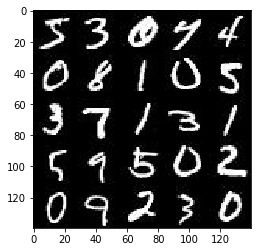

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

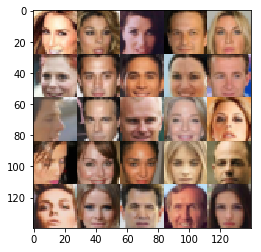

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learn_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smoothing_rate=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smoothing_rate)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
 
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #Get weights and biases to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, 
          data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every=10
    show_every=50
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
        
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #Sample random nose for theta
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0 # rescate from [-0.5, 0.5] to [-1, 1]
            
                #Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
            
                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.4629... Generator Loss: 2.9567
Epoch 0/2... Discriminator Loss: 0.3881... Generator Loss: 24.9578
Epoch 0/2... Discriminator Loss: 0.3365... Generator Loss: 10.8957
Epoch 0/2... Discriminator Loss: 0.3671... Generator Loss: 3.9153


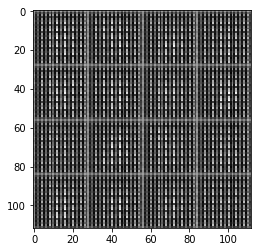

Epoch 0/2... Discriminator Loss: 0.3382... Generator Loss: 4.9581
Epoch 0/2... Discriminator Loss: 0.3833... Generator Loss: 3.3868
Epoch 0/2... Discriminator Loss: 0.3374... Generator Loss: 5.9098
Epoch 0/2... Discriminator Loss: 0.6888... Generator Loss: 1.2735
Epoch 0/2... Discriminator Loss: 1.2971... Generator Loss: 0.5084


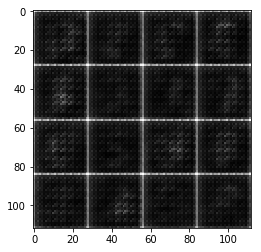

Epoch 0/2... Discriminator Loss: 0.9366... Generator Loss: 0.9901
Epoch 0/2... Discriminator Loss: 0.6171... Generator Loss: 1.6108
Epoch 0/2... Discriminator Loss: 0.7978... Generator Loss: 1.1509
Epoch 0/2... Discriminator Loss: 1.6079... Generator Loss: 1.3480
Epoch 0/2... Discriminator Loss: 1.3024... Generator Loss: 0.8822


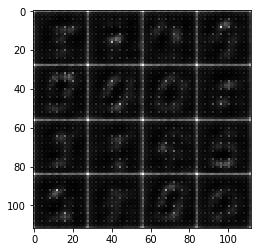

Epoch 0/2... Discriminator Loss: 1.0847... Generator Loss: 0.7037
Epoch 0/2... Discriminator Loss: 0.9718... Generator Loss: 1.0047
Epoch 0/2... Discriminator Loss: 0.9489... Generator Loss: 1.2191
Epoch 0/2... Discriminator Loss: 1.0977... Generator Loss: 1.0572
Epoch 0/2... Discriminator Loss: 1.0292... Generator Loss: 1.0734


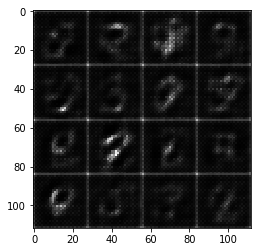

Epoch 0/2... Discriminator Loss: 1.3285... Generator Loss: 0.9184
Epoch 0/2... Discriminator Loss: 0.9205... Generator Loss: 1.6612
Epoch 0/2... Discriminator Loss: 1.0581... Generator Loss: 1.4440
Epoch 0/2... Discriminator Loss: 1.0110... Generator Loss: 0.8312
Epoch 0/2... Discriminator Loss: 2.1862... Generator Loss: 0.2083


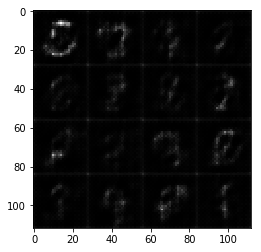

Epoch 0/2... Discriminator Loss: 1.5087... Generator Loss: 0.4621
Epoch 0/2... Discriminator Loss: 1.1331... Generator Loss: 0.6717
Epoch 0/2... Discriminator Loss: 1.1575... Generator Loss: 0.7005
Epoch 0/2... Discriminator Loss: 0.9838... Generator Loss: 1.0122
Epoch 0/2... Discriminator Loss: 1.1044... Generator Loss: 0.7365


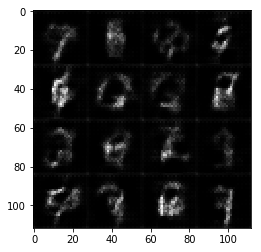

Epoch 0/2... Discriminator Loss: 1.3973... Generator Loss: 0.5048
Epoch 0/2... Discriminator Loss: 2.1776... Generator Loss: 0.2191
Epoch 0/2... Discriminator Loss: 1.8677... Generator Loss: 1.8068
Epoch 0/2... Discriminator Loss: 1.6447... Generator Loss: 0.3678
Epoch 0/2... Discriminator Loss: 1.2755... Generator Loss: 0.6241


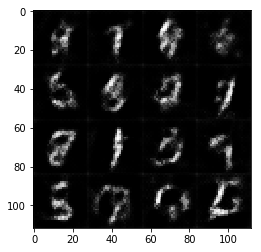

Epoch 0/2... Discriminator Loss: 1.4714... Generator Loss: 0.4738
Epoch 0/2... Discriminator Loss: 1.4859... Generator Loss: 0.4555
Epoch 0/2... Discriminator Loss: 1.6863... Generator Loss: 0.3390
Epoch 0/2... Discriminator Loss: 1.0635... Generator Loss: 0.8180
Epoch 0/2... Discriminator Loss: 0.7012... Generator Loss: 1.8991


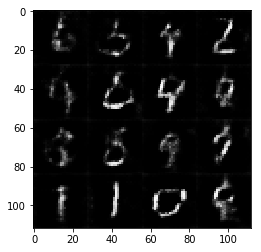

Epoch 0/2... Discriminator Loss: 1.8028... Generator Loss: 0.2974
Epoch 0/2... Discriminator Loss: 1.1270... Generator Loss: 0.7631
Epoch 0/2... Discriminator Loss: 1.4375... Generator Loss: 2.4024
Epoch 0/2... Discriminator Loss: 1.2940... Generator Loss: 0.8702
Epoch 0/2... Discriminator Loss: 2.1959... Generator Loss: 0.2328


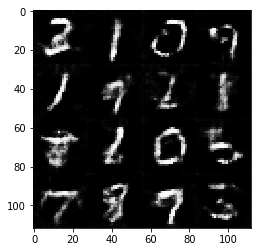

Epoch 0/2... Discriminator Loss: 1.9851... Generator Loss: 0.2638
Epoch 0/2... Discriminator Loss: 0.9592... Generator Loss: 1.2160
Epoch 0/2... Discriminator Loss: 0.8786... Generator Loss: 1.5214
Epoch 0/2... Discriminator Loss: 1.1006... Generator Loss: 0.7569
Epoch 0/2... Discriminator Loss: 0.8840... Generator Loss: 1.6523


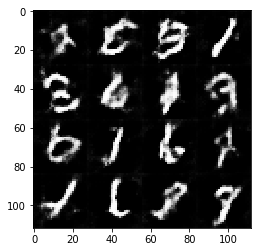

Epoch 0/2... Discriminator Loss: 1.0410... Generator Loss: 1.0695
Epoch 0/2... Discriminator Loss: 1.5729... Generator Loss: 0.4162
Epoch 0/2... Discriminator Loss: 1.6033... Generator Loss: 0.4013
Epoch 0/2... Discriminator Loss: 1.2010... Generator Loss: 2.3277
Epoch 0/2... Discriminator Loss: 1.0471... Generator Loss: 1.2585


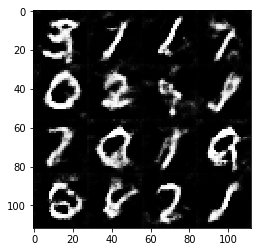

Epoch 0/2... Discriminator Loss: 1.0643... Generator Loss: 0.9290
Epoch 0/2... Discriminator Loss: 0.9119... Generator Loss: 1.9619
Epoch 0/2... Discriminator Loss: 0.9547... Generator Loss: 0.9407
Epoch 0/2... Discriminator Loss: 1.2133... Generator Loss: 1.0097
Epoch 0/2... Discriminator Loss: 0.9979... Generator Loss: 0.9864


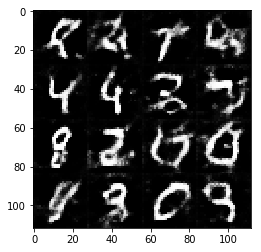

Epoch 0/2... Discriminator Loss: 1.0891... Generator Loss: 0.7570
Epoch 0/2... Discriminator Loss: 1.5487... Generator Loss: 0.4964
Epoch 0/2... Discriminator Loss: 1.3349... Generator Loss: 0.5986
Epoch 0/2... Discriminator Loss: 1.0196... Generator Loss: 1.6122
Epoch 0/2... Discriminator Loss: 0.9822... Generator Loss: 0.8900


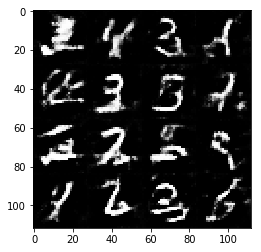

Epoch 0/2... Discriminator Loss: 0.9802... Generator Loss: 0.8907
Epoch 0/2... Discriminator Loss: 1.5375... Generator Loss: 0.5152
Epoch 0/2... Discriminator Loss: 1.5974... Generator Loss: 0.4048
Epoch 0/2... Discriminator Loss: 1.1158... Generator Loss: 2.3558
Epoch 0/2... Discriminator Loss: 0.9629... Generator Loss: 0.9513


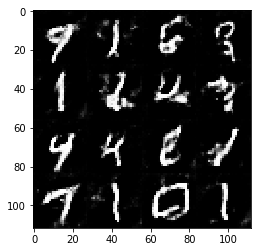

Epoch 0/2... Discriminator Loss: 1.1687... Generator Loss: 0.6473
Epoch 0/2... Discriminator Loss: 1.6810... Generator Loss: 0.4035
Epoch 0/2... Discriminator Loss: 1.2124... Generator Loss: 0.6075
Epoch 0/2... Discriminator Loss: 0.9305... Generator Loss: 1.0573
Epoch 0/2... Discriminator Loss: 2.5675... Generator Loss: 4.0004


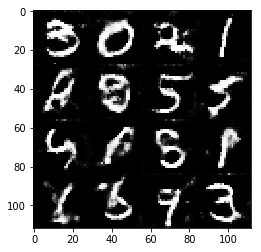

Epoch 0/2... Discriminator Loss: 0.9823... Generator Loss: 1.0673
Epoch 0/2... Discriminator Loss: 1.1192... Generator Loss: 1.5276
Epoch 0/2... Discriminator Loss: 0.8970... Generator Loss: 0.9826
Epoch 0/2... Discriminator Loss: 0.8170... Generator Loss: 1.4914
Epoch 0/2... Discriminator Loss: 0.8166... Generator Loss: 1.0974


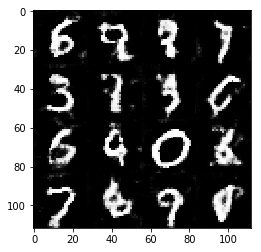

Epoch 0/2... Discriminator Loss: 0.8672... Generator Loss: 1.0577
Epoch 0/2... Discriminator Loss: 1.1949... Generator Loss: 0.7720
Epoch 0/2... Discriminator Loss: 1.2660... Generator Loss: 0.7151
Epoch 0/2... Discriminator Loss: 1.6435... Generator Loss: 0.3810
Epoch 0/2... Discriminator Loss: 0.7011... Generator Loss: 1.3104


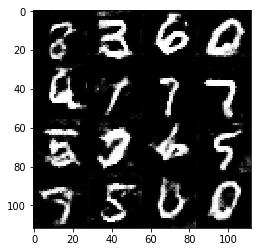

Epoch 0/2... Discriminator Loss: 1.0603... Generator Loss: 1.3221
Epoch 0/2... Discriminator Loss: 1.1211... Generator Loss: 0.7290
Epoch 0/2... Discriminator Loss: 0.9639... Generator Loss: 1.1182
Epoch 0/2... Discriminator Loss: 0.9587... Generator Loss: 0.9911
Epoch 0/2... Discriminator Loss: 1.0419... Generator Loss: 0.9455


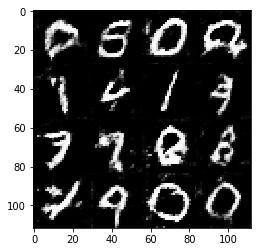

Epoch 0/2... Discriminator Loss: 1.3589... Generator Loss: 0.5419
Epoch 0/2... Discriminator Loss: 1.0970... Generator Loss: 0.7453
Epoch 0/2... Discriminator Loss: 1.1656... Generator Loss: 0.6979
Epoch 0/2... Discriminator Loss: 2.0575... Generator Loss: 0.3313
Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.8440


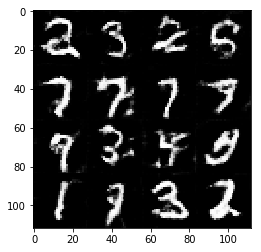

Epoch 1/2... Discriminator Loss: 1.2352... Generator Loss: 1.4827
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 0.5739
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 0.8379


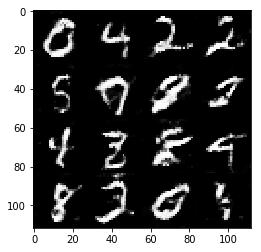

Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 2.0403... Generator Loss: 0.2618
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.8035


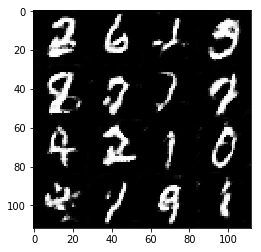

Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.8816
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 1.5956
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.4503


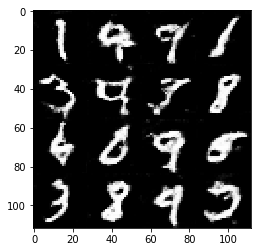

Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 1.0517... Generator Loss: 0.9198
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 0.9598
Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 2.7119


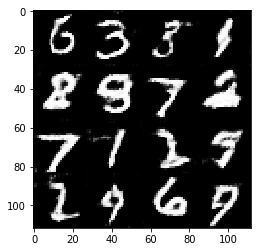

Epoch 1/2... Discriminator Loss: 0.9175... Generator Loss: 1.0088
Epoch 1/2... Discriminator Loss: 1.6079... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 1.7373... Generator Loss: 0.4297
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.0630


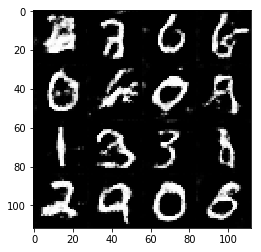

Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.4510
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.5571
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 1.7950... Generator Loss: 0.4079


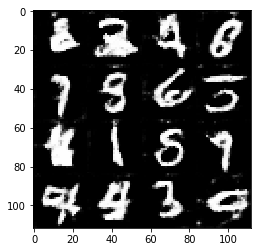

Epoch 1/2... Discriminator Loss: 1.8816... Generator Loss: 0.3550
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 2.5118... Generator Loss: 0.1711
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 0.8999


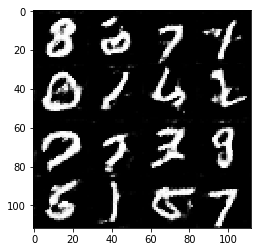

Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 0.7489... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.5930
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 2.3689
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 0.6903


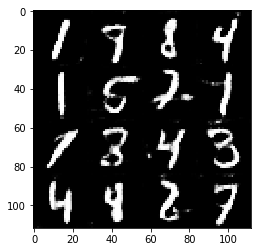

Epoch 1/2... Discriminator Loss: 1.8566... Generator Loss: 4.7187
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 0.9863
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.7566


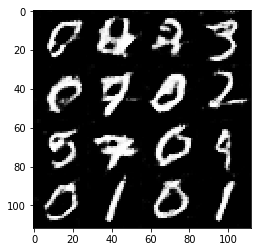

Epoch 1/2... Discriminator Loss: 1.7524... Generator Loss: 0.3436
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 0.9650
Epoch 1/2... Discriminator Loss: 2.2727... Generator Loss: 4.3705


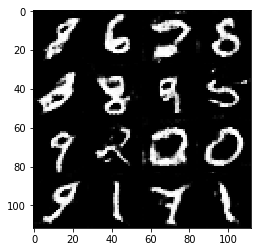

Epoch 1/2... Discriminator Loss: 1.6007... Generator Loss: 0.3875
Epoch 1/2... Discriminator Loss: 1.0211... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 1.2226
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 1.1198


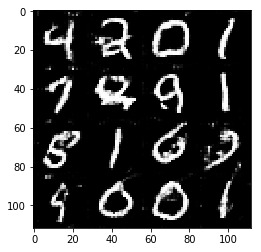

Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 2.0483... Generator Loss: 0.3066
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.3983... Generator Loss: 0.4933
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.7280


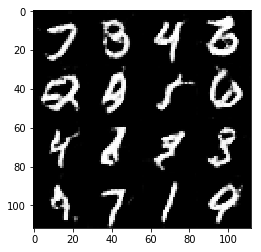

Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 2.1821
Epoch 1/2... Discriminator Loss: 2.3559... Generator Loss: 0.1837
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.7751... Generator Loss: 0.3498


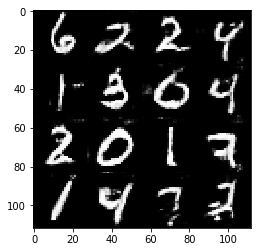

Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.4855
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 1.4260
Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 1.4423
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.4190
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.6345


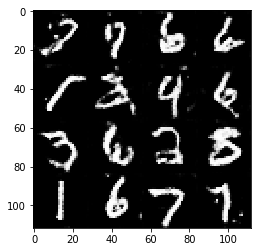

Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.5221
Epoch 1/2... Discriminator Loss: 1.7248... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 1.2839


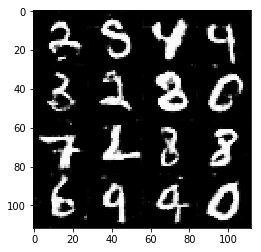

Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 0.3877
Epoch 1/2... Discriminator Loss: 1.8435... Generator Loss: 0.3691


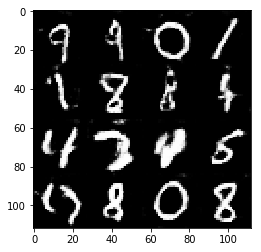

Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.7301
Epoch 1/2... Discriminator Loss: 1.6962... Generator Loss: 0.3631
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 0.8914
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.5456
Epoch 1/2... Discriminator Loss: 1.9664... Generator Loss: 0.3918


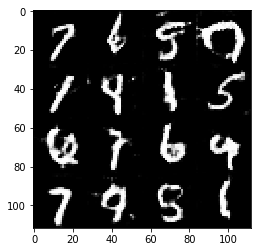

Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 0.4059
Epoch 1/2... Discriminator Loss: 1.5798... Generator Loss: 0.6611
Epoch 1/2... Discriminator Loss: 0.6147... Generator Loss: 1.8698
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 0.9670... Generator Loss: 1.3714


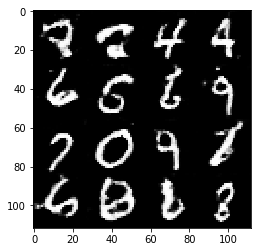

Epoch 1/2... Discriminator Loss: 2.1829... Generator Loss: 0.2279
Epoch 1/2... Discriminator Loss: 0.5698... Generator Loss: 1.7482
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.6673


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.6130... Generator Loss: 0.4989
Epoch 0/1... Discriminator Loss: 0.4953... Generator Loss: 2.6029
Epoch 0/1... Discriminator Loss: 0.8421... Generator Loss: 1.2064
Epoch 0/1... Discriminator Loss: 0.7230... Generator Loss: 1.5023


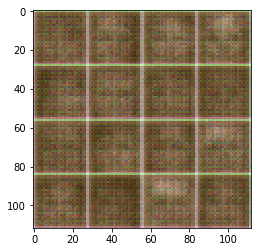

Epoch 0/1... Discriminator Loss: 0.7911... Generator Loss: 1.2772
Epoch 0/1... Discriminator Loss: 1.4621... Generator Loss: 0.4442
Epoch 0/1... Discriminator Loss: 1.4246... Generator Loss: 0.4624
Epoch 0/1... Discriminator Loss: 0.7296... Generator Loss: 1.1911
Epoch 0/1... Discriminator Loss: 2.2073... Generator Loss: 0.3581


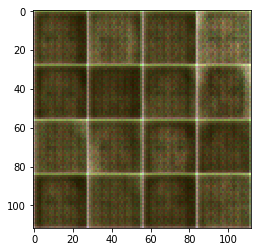

Epoch 0/1... Discriminator Loss: 0.7723... Generator Loss: 1.1510
Epoch 0/1... Discriminator Loss: 0.6259... Generator Loss: 1.6903
Epoch 0/1... Discriminator Loss: 1.0175... Generator Loss: 0.7536
Epoch 0/1... Discriminator Loss: 1.0111... Generator Loss: 0.8454
Epoch 0/1... Discriminator Loss: 0.5425... Generator Loss: 1.8094


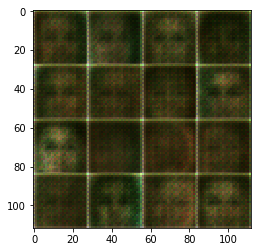

Epoch 0/1... Discriminator Loss: 1.4362... Generator Loss: 0.4498
Epoch 0/1... Discriminator Loss: 0.8316... Generator Loss: 1.0846
Epoch 0/1... Discriminator Loss: 0.7031... Generator Loss: 1.6556
Epoch 0/1... Discriminator Loss: 0.4763... Generator Loss: 2.1685
Epoch 0/1... Discriminator Loss: 1.1314... Generator Loss: 1.0804


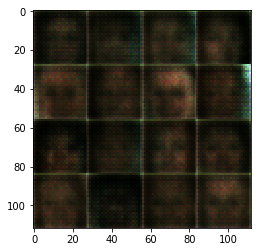

Epoch 0/1... Discriminator Loss: 1.3810... Generator Loss: 0.5245
Epoch 0/1... Discriminator Loss: 1.6491... Generator Loss: 0.3845
Epoch 0/1... Discriminator Loss: 1.4487... Generator Loss: 1.9168
Epoch 0/1... Discriminator Loss: 1.6403... Generator Loss: 2.2595
Epoch 0/1... Discriminator Loss: 1.2078... Generator Loss: 0.6052


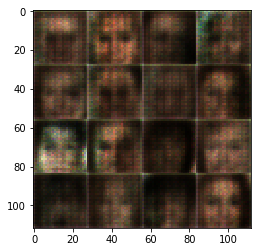

Epoch 0/1... Discriminator Loss: 1.5538... Generator Loss: 0.3770
Epoch 0/1... Discriminator Loss: 0.4538... Generator Loss: 3.7656
Epoch 0/1... Discriminator Loss: 0.5220... Generator Loss: 2.5899
Epoch 0/1... Discriminator Loss: 0.7293... Generator Loss: 1.3774
Epoch 0/1... Discriminator Loss: 0.7695... Generator Loss: 4.9745


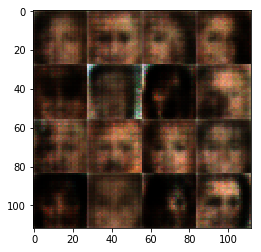

Epoch 0/1... Discriminator Loss: 0.5087... Generator Loss: 1.9655
Epoch 0/1... Discriminator Loss: 1.2203... Generator Loss: 0.9728
Epoch 0/1... Discriminator Loss: 0.6227... Generator Loss: 1.6416
Epoch 0/1... Discriminator Loss: 0.8701... Generator Loss: 1.5860
Epoch 0/1... Discriminator Loss: 1.0968... Generator Loss: 1.7611


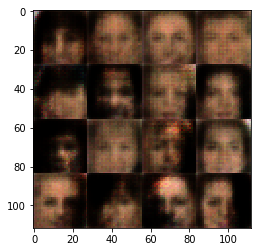

Epoch 0/1... Discriminator Loss: 0.4336... Generator Loss: 2.5035
Epoch 0/1... Discriminator Loss: 1.6063... Generator Loss: 1.2415
Epoch 0/1... Discriminator Loss: 0.9626... Generator Loss: 0.9690
Epoch 0/1... Discriminator Loss: 1.1494... Generator Loss: 3.6078
Epoch 0/1... Discriminator Loss: 0.7656... Generator Loss: 1.4174


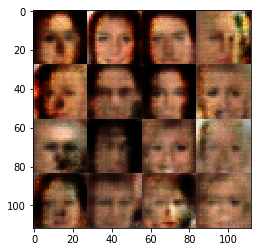

Epoch 0/1... Discriminator Loss: 0.7811... Generator Loss: 1.4159
Epoch 0/1... Discriminator Loss: 0.7315... Generator Loss: 1.2088
Epoch 0/1... Discriminator Loss: 0.6653... Generator Loss: 1.4273
Epoch 0/1... Discriminator Loss: 1.3618... Generator Loss: 0.5133
Epoch 0/1... Discriminator Loss: 0.8939... Generator Loss: 2.7055


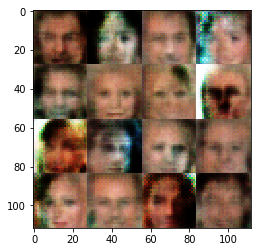

Epoch 0/1... Discriminator Loss: 0.5768... Generator Loss: 2.2296
Epoch 0/1... Discriminator Loss: 0.8059... Generator Loss: 1.0517
Epoch 0/1... Discriminator Loss: 1.3562... Generator Loss: 0.4941
Epoch 0/1... Discriminator Loss: 1.3051... Generator Loss: 0.5620
Epoch 0/1... Discriminator Loss: 1.1181... Generator Loss: 0.7319


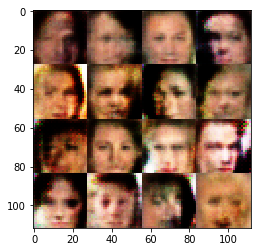

Epoch 0/1... Discriminator Loss: 0.8577... Generator Loss: 1.2548
Epoch 0/1... Discriminator Loss: 0.4861... Generator Loss: 2.1618
Epoch 0/1... Discriminator Loss: 0.8540... Generator Loss: 1.5165
Epoch 0/1... Discriminator Loss: 1.1024... Generator Loss: 0.9418
Epoch 0/1... Discriminator Loss: 0.9679... Generator Loss: 2.3785


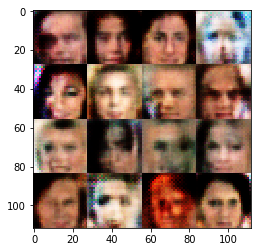

Epoch 0/1... Discriminator Loss: 0.6090... Generator Loss: 1.5904
Epoch 0/1... Discriminator Loss: 0.8074... Generator Loss: 1.3280
Epoch 0/1... Discriminator Loss: 0.6568... Generator Loss: 1.3883
Epoch 0/1... Discriminator Loss: 1.1221... Generator Loss: 0.7199
Epoch 0/1... Discriminator Loss: 0.8393... Generator Loss: 1.4495


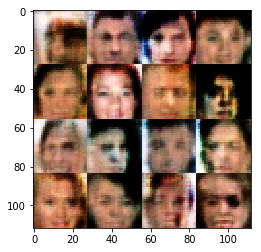

Epoch 0/1... Discriminator Loss: 1.3689... Generator Loss: 0.5153
Epoch 0/1... Discriminator Loss: 1.1788... Generator Loss: 0.6200
Epoch 0/1... Discriminator Loss: 2.1445... Generator Loss: 1.9779
Epoch 0/1... Discriminator Loss: 1.0521... Generator Loss: 0.7774
Epoch 0/1... Discriminator Loss: 1.1299... Generator Loss: 1.8469


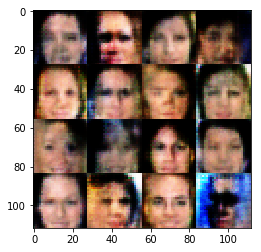

Epoch 0/1... Discriminator Loss: 1.0582... Generator Loss: 0.7186
Epoch 0/1... Discriminator Loss: 1.0745... Generator Loss: 0.9017
Epoch 0/1... Discriminator Loss: 1.2904... Generator Loss: 0.5237
Epoch 0/1... Discriminator Loss: 0.7882... Generator Loss: 1.1091
Epoch 0/1... Discriminator Loss: 2.1919... Generator Loss: 2.5727


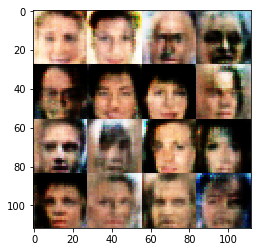

Epoch 0/1... Discriminator Loss: 0.9075... Generator Loss: 2.2884
Epoch 0/1... Discriminator Loss: 1.2275... Generator Loss: 3.7540
Epoch 0/1... Discriminator Loss: 0.9682... Generator Loss: 0.9297
Epoch 0/1... Discriminator Loss: 1.3669... Generator Loss: 0.4653
Epoch 0/1... Discriminator Loss: 0.7142... Generator Loss: 1.3059


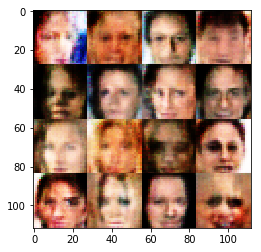

Epoch 0/1... Discriminator Loss: 0.6864... Generator Loss: 1.7278
Epoch 0/1... Discriminator Loss: 1.3776... Generator Loss: 2.2385
Epoch 0/1... Discriminator Loss: 1.0128... Generator Loss: 2.2719
Epoch 0/1... Discriminator Loss: 1.4570... Generator Loss: 0.4225
Epoch 0/1... Discriminator Loss: 0.7236... Generator Loss: 1.1988


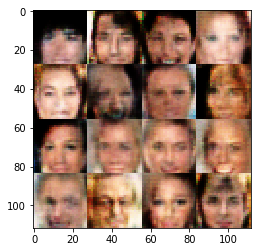

Epoch 0/1... Discriminator Loss: 1.5147... Generator Loss: 1.3183
Epoch 0/1... Discriminator Loss: 1.2667... Generator Loss: 0.6287
Epoch 0/1... Discriminator Loss: 1.1470... Generator Loss: 0.6910
Epoch 0/1... Discriminator Loss: 1.2018... Generator Loss: 0.5840
Epoch 0/1... Discriminator Loss: 0.9668... Generator Loss: 2.1453


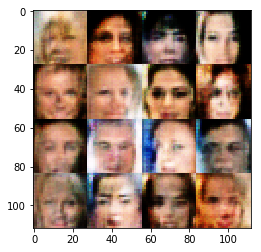

Epoch 0/1... Discriminator Loss: 0.9907... Generator Loss: 0.8685
Epoch 0/1... Discriminator Loss: 1.3855... Generator Loss: 0.4578
Epoch 0/1... Discriminator Loss: 0.7665... Generator Loss: 2.6888
Epoch 0/1... Discriminator Loss: 1.4165... Generator Loss: 0.4607
Epoch 0/1... Discriminator Loss: 0.9348... Generator Loss: 0.8686


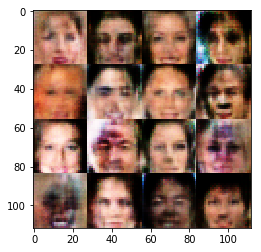

Epoch 0/1... Discriminator Loss: 1.0495... Generator Loss: 0.7148
Epoch 0/1... Discriminator Loss: 0.9594... Generator Loss: 1.5798
Epoch 0/1... Discriminator Loss: 0.9209... Generator Loss: 0.8848
Epoch 0/1... Discriminator Loss: 1.2306... Generator Loss: 0.5639
Epoch 0/1... Discriminator Loss: 1.1932... Generator Loss: 0.6116


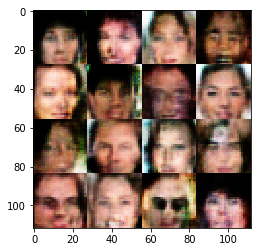

Epoch 0/1... Discriminator Loss: 1.6574... Generator Loss: 0.3338
Epoch 0/1... Discriminator Loss: 1.0372... Generator Loss: 0.7326
Epoch 0/1... Discriminator Loss: 0.7250... Generator Loss: 2.4867
Epoch 0/1... Discriminator Loss: 0.9824... Generator Loss: 0.9521
Epoch 0/1... Discriminator Loss: 0.9473... Generator Loss: 0.8551


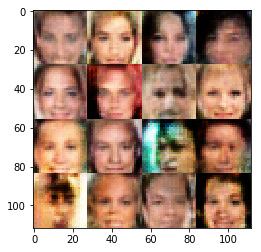

Epoch 0/1... Discriminator Loss: 0.8775... Generator Loss: 2.6999
Epoch 0/1... Discriminator Loss: 1.3509... Generator Loss: 0.5062
Epoch 0/1... Discriminator Loss: 1.6302... Generator Loss: 0.3444
Epoch 0/1... Discriminator Loss: 0.8885... Generator Loss: 1.3828
Epoch 0/1... Discriminator Loss: 1.0646... Generator Loss: 0.7516


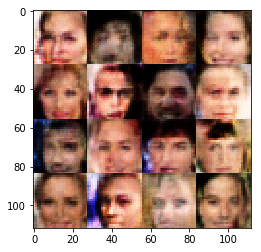

Epoch 0/1... Discriminator Loss: 0.8853... Generator Loss: 1.0074
Epoch 0/1... Discriminator Loss: 1.0276... Generator Loss: 1.0709
Epoch 0/1... Discriminator Loss: 1.8251... Generator Loss: 0.2871
Epoch 0/1... Discriminator Loss: 1.0100... Generator Loss: 0.7979
Epoch 0/1... Discriminator Loss: 0.7264... Generator Loss: 1.5420


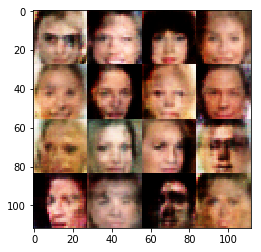

Epoch 0/1... Discriminator Loss: 1.3826... Generator Loss: 2.9954
Epoch 0/1... Discriminator Loss: 0.6937... Generator Loss: 1.7508
Epoch 0/1... Discriminator Loss: 0.6195... Generator Loss: 2.3569
Epoch 0/1... Discriminator Loss: 0.7083... Generator Loss: 1.2317
Epoch 0/1... Discriminator Loss: 1.2266... Generator Loss: 0.6306


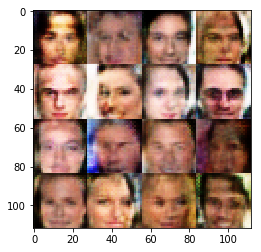

Epoch 0/1... Discriminator Loss: 1.0211... Generator Loss: 0.7504
Epoch 0/1... Discriminator Loss: 0.7949... Generator Loss: 1.0806
Epoch 0/1... Discriminator Loss: 0.7715... Generator Loss: 1.2232
Epoch 0/1... Discriminator Loss: 1.2952... Generator Loss: 2.2788
Epoch 0/1... Discriminator Loss: 0.7032... Generator Loss: 1.3214


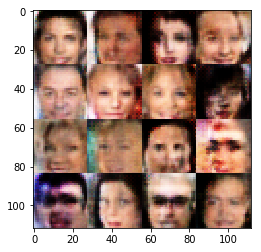

Epoch 0/1... Discriminator Loss: 0.7708... Generator Loss: 1.1239
Epoch 0/1... Discriminator Loss: 0.7904... Generator Loss: 1.3120
Epoch 0/1... Discriminator Loss: 1.0264... Generator Loss: 1.6048
Epoch 0/1... Discriminator Loss: 1.0624... Generator Loss: 1.7980
Epoch 0/1... Discriminator Loss: 1.1959... Generator Loss: 0.6207


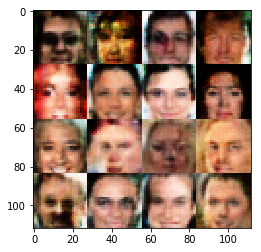

Epoch 0/1... Discriminator Loss: 1.2320... Generator Loss: 0.6734
Epoch 0/1... Discriminator Loss: 1.1250... Generator Loss: 1.9554
Epoch 0/1... Discriminator Loss: 0.9625... Generator Loss: 2.6495
Epoch 0/1... Discriminator Loss: 0.9866... Generator Loss: 1.9731
Epoch 0/1... Discriminator Loss: 0.7241... Generator Loss: 1.7060


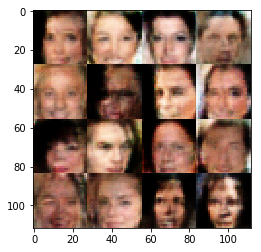

Epoch 0/1... Discriminator Loss: 1.2841... Generator Loss: 0.5536
Epoch 0/1... Discriminator Loss: 1.1897... Generator Loss: 0.5967
Epoch 0/1... Discriminator Loss: 0.9512... Generator Loss: 1.8124
Epoch 0/1... Discriminator Loss: 2.1789... Generator Loss: 1.5463
Epoch 0/1... Discriminator Loss: 0.7774... Generator Loss: 1.9047


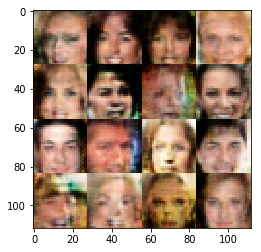

Epoch 0/1... Discriminator Loss: 0.5332... Generator Loss: 2.0174
Epoch 0/1... Discriminator Loss: 1.3597... Generator Loss: 0.4928
Epoch 0/1... Discriminator Loss: 1.2266... Generator Loss: 0.5668
Epoch 0/1... Discriminator Loss: 1.1045... Generator Loss: 1.2866
Epoch 0/1... Discriminator Loss: 1.2394... Generator Loss: 0.5797


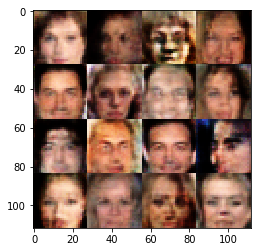

Epoch 0/1... Discriminator Loss: 1.1829... Generator Loss: 0.6052
Epoch 0/1... Discriminator Loss: 1.1134... Generator Loss: 0.6775
Epoch 0/1... Discriminator Loss: 1.4945... Generator Loss: 2.4402
Epoch 0/1... Discriminator Loss: 1.0671... Generator Loss: 0.8607
Epoch 0/1... Discriminator Loss: 0.9878... Generator Loss: 2.2379


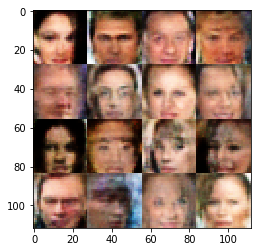

Epoch 0/1... Discriminator Loss: 0.8622... Generator Loss: 1.2819
Epoch 0/1... Discriminator Loss: 2.1380... Generator Loss: 0.2159
Epoch 0/1... Discriminator Loss: 1.0695... Generator Loss: 0.7092
Epoch 0/1... Discriminator Loss: 0.6977... Generator Loss: 3.0448
Epoch 0/1... Discriminator Loss: 1.2766... Generator Loss: 0.5314


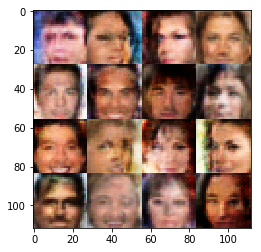

Epoch 0/1... Discriminator Loss: 1.1426... Generator Loss: 0.7789
Epoch 0/1... Discriminator Loss: 0.9126... Generator Loss: 1.5952
Epoch 0/1... Discriminator Loss: 1.2348... Generator Loss: 0.5647
Epoch 0/1... Discriminator Loss: 0.9372... Generator Loss: 0.8875
Epoch 0/1... Discriminator Loss: 1.0351... Generator Loss: 0.8187


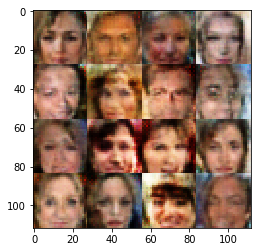

Epoch 0/1... Discriminator Loss: 0.6689... Generator Loss: 1.9295
Epoch 0/1... Discriminator Loss: 1.0856... Generator Loss: 0.6839
Epoch 0/1... Discriminator Loss: 0.8855... Generator Loss: 0.9694
Epoch 0/1... Discriminator Loss: 0.8264... Generator Loss: 1.0375


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.